#Check GPU

In [2]:
# Check that a GPU is available in Colab.

!nvidia-smi -L || echo


GPU 0: Tesla T4 (UUID: GPU-387f2a15-e209-4177-c3c8-13948c687d91)


#Install Kaggle package

In [3]:
# Kaggle lets us download datasets directly using the Kaggle API.

!pip install -q kaggle

#Install split-folders

In [4]:
# This package automatically divides our dataset
# into train / validation / test folders with a given ratio.

!pip install -q split-folders==0.5.1

#Import required Python libraries

In [5]:
# - os, glob, shutil, json → for file and folder operations
# - random, numpy → for numeric calculations and reproducibility
# - tensorflow → main deep learning library (for CNN)

import os, glob, shutil, json, random
import numpy as np
import tensorflow as tf


#Set random seeds for reproducibility

In [6]:
# This ensures the model results remain the same
# every time you run the notebook.

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


#Verify TensorFlow version and GPU availability

In [7]:
# - Check TensorFlow version (we need >= 2.10)
# - Verify GPU is visible to TensorFlow for faster training

print("TensorFlow version:", tf.__version__)
print("GPUs visible to TensorFlow:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPUs visible to TensorFlow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#Create folder paths for our project

In [8]:
# Create main folder paths
# - Original dataset (downloaded from Kaggle) in /content/data
# - Train/Val/Test split dataset in /content/tea_splits
# - Saved models & results in /content/artifacts

DATA_ROOT = "/content/data"          # Original dataset
SPLIT_ROOT = "/content/tea_splits"   # After splitting into train/val/test
ARTIFACTS_DIR = "/content/artifacts" # For saved models, graphs, etc.

# Create the folders if they don't exist

import os
os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(SPLIT_ROOT, exist_ok=True)
os.makedirs(ARTIFACTS_DIR, exist_ok=True)


#Download dataset using opendatasets

In [9]:
# This method lets you directly type your Kaggle username and key (safe for Colab).
# It will automatically download and unzip the dataset into /content/data.

!pip install -q opendatasets

import opendatasets as od

# Dataset URL
dataset_url = "https://www.kaggle.com/datasets/uthpalabandara/common-diseases-of-tea-leaves-in-sri-lanka"

# Download the dataset (you will be prompted for Kaggle username & key)
od.download(dataset_url, data_dir="/content/data")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jananihansika
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/uthpalabandara/common-diseases-of-tea-leaves-in-sri-lanka


100%|██████████| 960M/960M [00:08<00:00, 116MB/s]


#Verify the dataset structure

In [10]:
# Verify that the dataset was downloaded and extracted correctly
# We'll check the folder inside /content/data and list all subfolders.

!ls -R /content/data


/content/data:
common-diseases-of-tea-leaves-in-sri-lanka

/content/data/common-diseases-of-tea-leaves-in-sri-lanka:
'Algal Leaf'  'Bird Eye Spot'  'Gray Light'  'Red Leaf Spot'
 Anthracnose  'Brown Blight'    Healthy      'White Spot'

'/content/data/common-diseases-of-tea-leaves-in-sri-lanka/Algal Leaf':
'Algal Leaf'

'/content/data/common-diseases-of-tea-leaves-in-sri-lanka/Algal Leaf/Algal Leaf':
 UNADJUSTEDNONRAW_thumb_10.jpg		 UNADJUSTEDNONRAW_thumb_45.jpg
 UNADJUSTEDNONRAW_thumb_11.jpg		 UNADJUSTEDNONRAW_thumb_46.jpg
 UNADJUSTEDNONRAW_thumb_12.jpg		 UNADJUSTEDNONRAW_thumb_47.jpg
 UNADJUSTEDNONRAW_thumb_13.jpg		 UNADJUSTEDNONRAW_thumb_48.jpg
 UNADJUSTEDNONRAW_thumb_14.jpg		 UNADJUSTEDNONRAW_thumb_49.jpg
 UNADJUSTEDNONRAW_thumb_15.jpg		'UNADJUSTEDNONRAW_thumb_4a - Copy.jpg'
 UNADJUSTEDNONRAW_thumb_16.jpg		 UNADJUSTEDNONRAW_thumb_4a.jpg
 UNADJUSTEDNONRAW_thumb_17.jpg		'UNADJUSTEDNONRAW_thumb_4b - Copy.jpg'
 UNADJUSTEDNONRAW_thumb_18.jpg		 UNADJUSTEDNONRAW_thumb_4b.jpg
 UNADJUSTEDNO

#Flatten the folder structure

In [11]:
import os, shutil

# Flatten nested folders (move inner images up one level)
root_dir = "/content/data/common-diseases-of-tea-leaves-in-sri-lanka"

for class_folder in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_folder)
    if os.path.isdir(class_path):
        inner_path = os.path.join(class_path, class_folder)
        if os.path.exists(inner_path):
            for file in os.listdir(inner_path):
                shutil.move(os.path.join(inner_path, file), class_path)
            shutil.rmtree(inner_path)  # remove the empty inner folder


!ls /content/data/common-diseases-of-tea-leaves-in-sri-lanka


'Algal Leaf'  'Bird Eye Spot'  'Gray Light'  'Red Leaf Spot'
 Anthracnose  'Brown Blight'    Healthy      'White Spot'


#Split the dataset

In [12]:
# Split dataset into train, validation, test folders using split-folders

import splitfolders

input_folder = "/content/data/common-diseases-of-tea-leaves-in-sri-lanka"
output_folder = "/content/tea_splits"

splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,        # for reproducibility
    ratio=(0.7, 0.2, 0.1),   # train, validation, test
    move=False      # copy files instead of moving
)


Copying files: 1196 files [00:04, 243.39 files/s]


#Verify the split

In [13]:
!ls -R /content/tea_splits


/content/tea_splits:
test  train  val

/content/tea_splits/test:
'Algal Leaf'  'Bird Eye Spot'  'Gray Light'  'Red Leaf Spot'
 Anthracnose  'Brown Blight'    Healthy      'White Spot'

'/content/tea_splits/test/Algal Leaf':
 UNADJUSTEDNONRAW_thumb_14.jpg		 UNADJUSTEDNONRAW_thumb_35.jpg
 UNADJUSTEDNONRAW_thumb_15.jpg		 UNADJUSTEDNONRAW_thumb_37.jpg
 UNADJUSTEDNONRAW_thumb_16.jpg		 UNADJUSTEDNONRAW_thumb_39.jpg
'UNADJUSTEDNONRAW_thumb_1f - Copy.jpg'	'UNADJUSTEDNONRAW_thumb_3b - Copy.jpg'
 UNADJUSTEDNONRAW_thumb_1f.jpg		'UNADJUSTEDNONRAW_thumb_3f - Copy.jpg'
 UNADJUSTEDNONRAW_thumb_20.jpg		'UNADJUSTEDNONRAW_thumb_5a - Copy.jpg'
 UNADJUSTEDNONRAW_thumb_22.jpg		 UNADJUSTEDNONRAW_thumb_67.jpg
 UNADJUSTEDNONRAW_thumb_29.jpg		 UNADJUSTEDNONRAW_thumb_6d.jpg

/content/tea_splits/test/Anthracnose:
 IMG_20220503_143328.jpg	   IMG_20220503_144533.jpg
 IMG_20220503_143424.jpg	   IMG_20220503_144934.jpg
'IMG_20220503_143433 - Copy.jpg'   IMG_20220503_145035.jpg
 IMG_20220503_143441.jpg	   IMG_2022050

#Import & setup image preprocessing library

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#Define dataset folder paths

In [15]:
# Now let’s tell Python where your train, validation, and test images are.

train_dir = "/content/tea_splits/train"
val_dir = "/content/tea_splits/val"
test_dir = "/content/tea_splits/test"


#Set the image size and batch size

In [16]:
# These values tell the model how large each image should be and how many images to process at once.

IMG_SIZE = (128, 128)
BATCH_SIZE = 32


#Create data augmentation for the training images

In [17]:
# This helps your model learn better by slightly changing images (rotating, flipping, zooming, etc.) during training.

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


#Create preprocessing for validation and test images

In [18]:
# Validation and test data should not be augmented — they’re only normalized (rescaled).

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


#Load images using the generators

In [19]:
# Now we’ll load the images from our folders into memory in batches.

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 835 images belonging to 8 classes.
Found 236 images belonging to 8 classes.
Found 125 images belonging to 8 classes.


#Verify one batch of images

In [20]:
# Now let’s check if the images and labels are coming in the right shape.

x_batch, y_batch = next(train_generator)
print("Image batch shape:", x_batch.shape)
print("Label batch shape:", y_batch.shape)


Image batch shape: (32, 128, 128, 3)
Label batch shape: (32, 8)


#Now build our Custom CNN Model

In [21]:
# importing the required TensorFlow and Keras layers.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


#Create the CNN model architecture

In [22]:
# This model will have convolution layers for feature extraction and dense layers for classification.

from tensorflow.keras import Input

model = Sequential([
    Input(shape=(128, 128, 3)),

    # 1st Convolution Block
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # 2nd Convolution Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # 3rd Convolution Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten + Dense Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')
])


#Compile the CNN Model

In [23]:
# tell the model how to learn by defining the optimizer, loss function, and performance metric.
# optimizer='adam' → adjusts learning rate automatically for faster convergence.
# loss='categorical_crossentropy' → good for multi-class classification (you have 8 classes).
# metrics=['accuracy'] → helps track how well the model performs during training.

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


#Train the CNN model

In [24]:
# train_generator → provides training images
# validation_data → checks accuracy after each epoch
# epochs=15 → the number of full passes over the dataset (we can tune this later)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.3429 - loss: 5.7379 - val_accuracy: 0.1186 - val_loss: 3.9166
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4058 - loss: 3.6288 - val_accuracy: 0.1314 - val_loss: 8.8667
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4212 - loss: 2.0153 - val_accuracy: 0.1653 - val_loss: 12.6123
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4649 - loss: 1.6249 - val_accuracy: 0.1186 - val_loss: 14.3197
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4644 - loss: 1.6328 - val_accuracy: 0.1186 - val_loss: 11.6170
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4890 - loss: 1.3637 - val_accuracy: 0.2373 - val_loss: 14.9583
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4533 - loss: 1.9923 - val_accuracy: 0.2161 - val_loss: 5.1137
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4547 - loss: 2.2370 - val_accuracy: 0.1737 - val_l

#Plot Training & Validation Accuracy/Loss Graphs

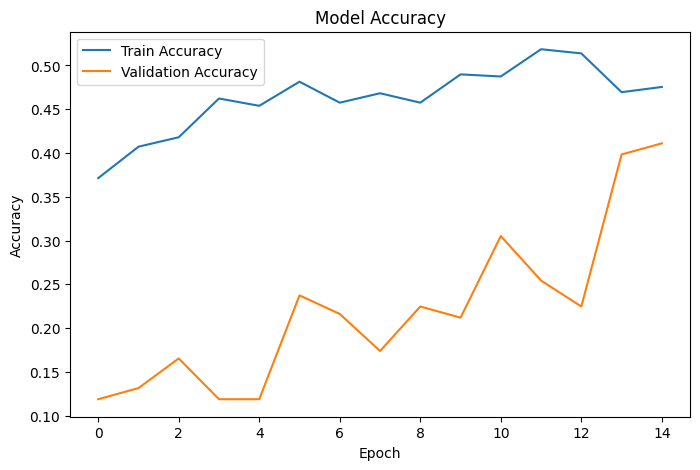

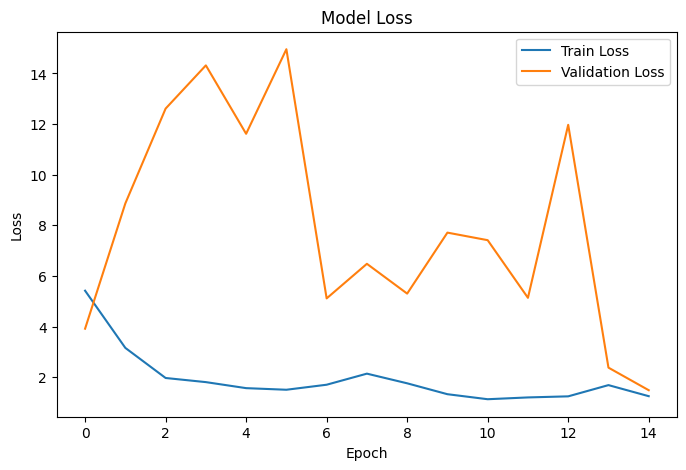

In [25]:
# visualize the learning performance (to see how accuracy and loss changed during training).
# show two graphs: Accuracy vs Epochs , Loss vs Epochs

# Train accuracy is improving steadily → model is learning.
# Validation accuracy is still lower, meaning the model hasn’t generalized well yet (we’ll fix that soon by tuning and dropout).
# Validation loss fluctuates early but decreases near the end → the model is starting to stabilize.

import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


#Evaluate the model on test data

In [26]:
# Evaluate model on test dataset

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3640 - loss: 1.1871
Test Accuracy: 38.40%
Test Loss: 1.2348


#Visualize Model Predictions on Test Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


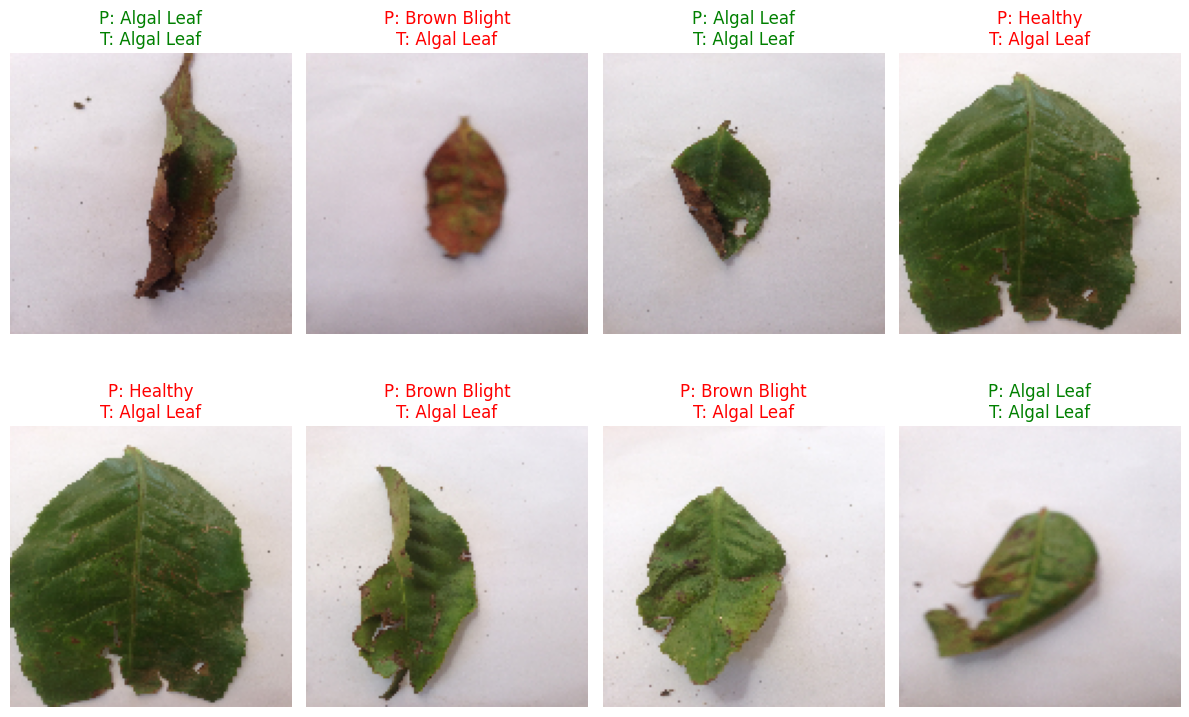

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Predict a few images from test set
test_imgs, test_labels = next(test_generator)
predictions = model.predict(test_imgs)

# Show first 8 images with predicted and true labels
plt.figure(figsize=(12, 8))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(test_imgs[i])
    true_label = class_labels[np.argmax(test_labels[i])]
    pred_label = class_labels[np.argmax(predictions[i])]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()


#Add Data Augmentation & Regularization

In [28]:
# replaces the model definition and retraining parts

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers

# Recreate generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(128,128), batch_size=32, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(128,128), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(128,128), batch_size=32, class_mode='categorical')

# Rebuild CNN with dropout layers
model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(8, activation='softmax')
])

# Compile
model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Retrain with augmentation
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=val_generator)


Found 835 images belonging to 8 classes.
Found 236 images belonging to 8 classes.
Found 125 images belonging to 8 classes.
Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.1555 - loss: 2.0834 - val_accuracy: 0.2627 - val_loss: 1.7772
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3222 - loss: 1.6975 - val_accuracy: 0.3898 - val_loss: 1.2846
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3652 - loss: 1.3492 - val_accuracy: 0.4025 - val_loss: 1.1679
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3757 - loss: 1.2883 - val_accuracy: 0.3686 - val_loss: 1.4263
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3866 - loss: 1.3492 - val_accuracy: 0.4110 - val_loss: 1.2002
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4537 - loss: 1.1750 - val_accuracy: 0.4576 - val_loss: 1.1894
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4722 - loss: 1.1285 - val_accuracy: 0.5508 - val_loss: 1.

#Evaluate on Test Data

In [29]:
# Evaluate final model on test dataset

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7699 - loss: 0.6067
Final Test Accuracy: 78.40%
Final Test Loss: 0.5748


#Visualize Final Predictions (True vs Predicted)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


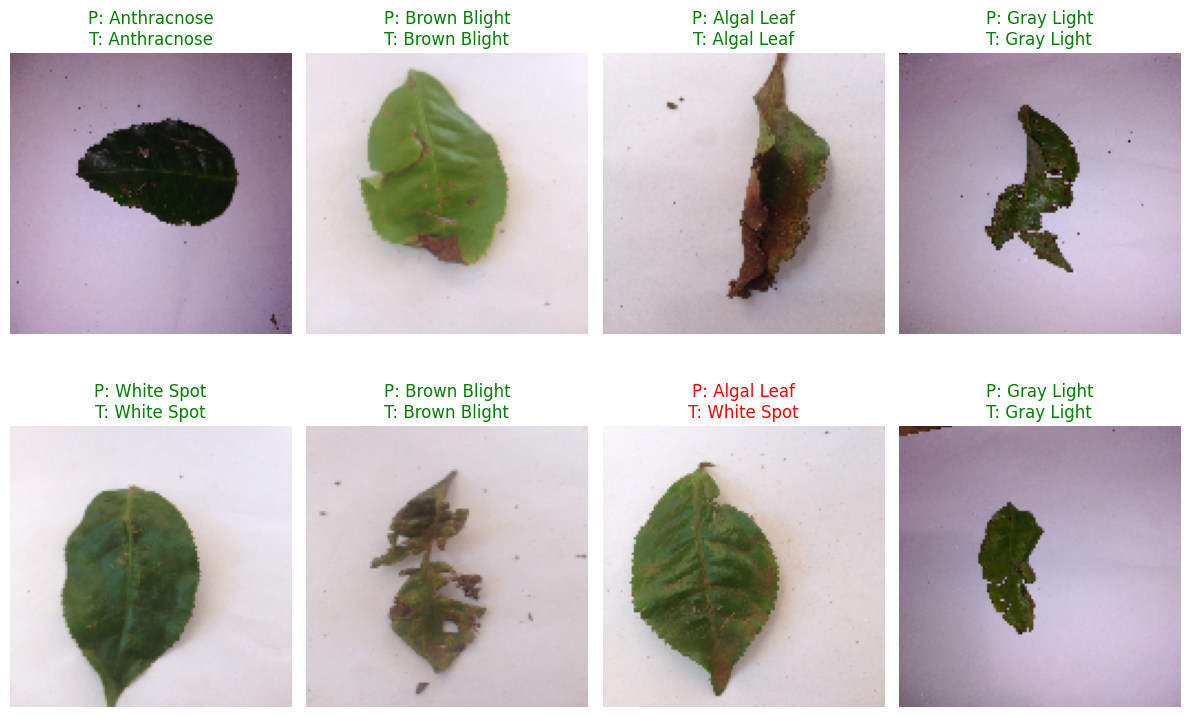

In [30]:
# display sample test images with model’s predictions

import numpy as np
import matplotlib.pyplot as plt

# Get class labels from the generator
class_labels = list(train_generator.class_indices.keys())

# Take one batch from the test set
test_imgs, test_labels = next(test_generator)

# Predict
predictions = model.predict(test_imgs)

# Plot first 8 results
plt.figure(figsize=(12, 8))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(test_imgs[i])
    true_label = class_labels[np.argmax(test_labels[i])]
    pred_label = class_labels[np.argmax(predictions[i])]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()


#Save Trained Model (.h5)

In [31]:
# Save the trained model

model.save("tea_leaf_disease_model.h5")

print("✅ Model saved successfully as tea_leaf_disease_model.h5")


✅ Model saved successfully as tea_leaf_disease_model.h5


#Load and Test a Single Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


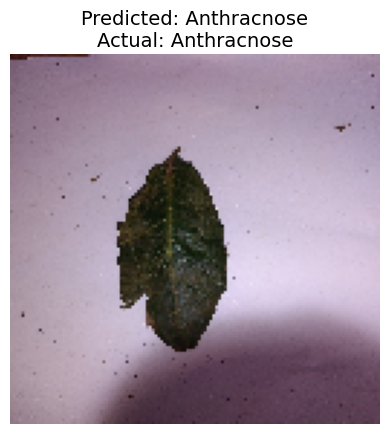

 Predicted Class: Anthracnose
 Actual Class: Anthracnose


In [32]:
# load one leaf image and let model predict its disease class (real-world testing).

import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the saved model
model = load_model("tea_leaf_disease_model.h5")

# Get all test image paths
test_dir = "/content/tea_splits/test"
all_classes = os.listdir(test_dir)
chosen_class = random.choice(all_classes)
chosen_image = random.choice(os.listdir(os.path.join(test_dir, chosen_class)))

# Build full path
img_path = os.path.join(test_dir, chosen_class, chosen_image)

# Preprocess the image
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
pred = model.predict(img_array)
class_labels = list(train_generator.class_indices.keys())
predicted_class = class_labels[np.argmax(pred)]

# Display image and prediction
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}\nActual: {chosen_class}", fontsize=14)
plt.axis("off")
plt.show()

print(f" Predicted Class: {predicted_class}")
print(f" Actual Class: {chosen_class}")




#confusion matrix to show per-class performance

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


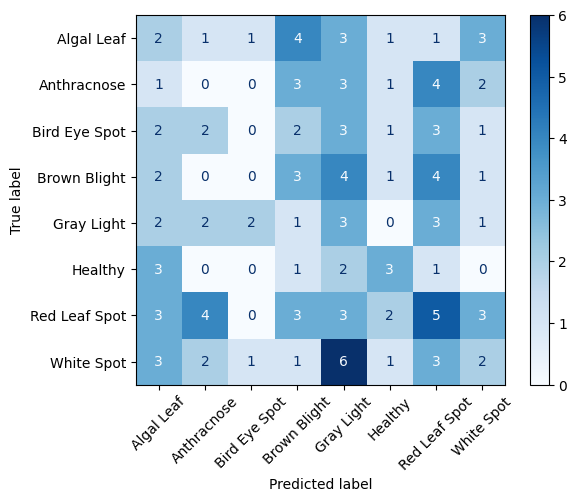

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=list(train_generator.class_indices.keys()))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.show()


#Print a classification report

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))


               precision    recall  f1-score   support

   Algal Leaf       0.11      0.12      0.12        16
  Anthracnose       0.00      0.00      0.00        14
Bird Eye Spot       0.00      0.00      0.00        14
 Brown Blight       0.17      0.20      0.18        15
   Gray Light       0.11      0.21      0.15        14
      Healthy       0.30      0.30      0.30        10
Red Leaf Spot       0.21      0.22      0.21        23
   White Spot       0.15      0.11      0.12        19

     accuracy                           0.14       125
    macro avg       0.13      0.15      0.14       125
 weighted avg       0.13      0.14      0.14       125

